<a href="https://colab.research.google.com/github/rezatan/LoanCustomer/blob/main/LoanCustomer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Mhd Reza Putra

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_absolute_error

In [2]:
from matplotlib import rcParams

rcParams['figure.figsize'] = (12, 4)
rcParams['lines.linewidth'] = 3
rcParams['xtick.labelsize'] = 'small'
rcParams['ytick.labelsize'] = 'small'

# Load Dataset

In [3]:
df = pd.read_csv('loan_customer.csv')

In [4]:
df['birth_date'] = pd.to_datetime(df['birth_date'])

In [5]:
cats = ['gender', 'married', 'dependents', 'education', 'self_employed', 'property_type']
nums = ['applicant_income', 'coapplicant_income', 'loan_amount', 'loan_term_month', 'loan_term_year', 'credit_history']

In [6]:
df[cats].describe()

,gender,married,dependents,education,self_employed,property_type
count,608,618,605,620,588,620
unique,2,2,4,2,2,3
top,Male,Yes,0,Graduate,No,apartment
freq,495,403,349,485,506,235


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621 entries, 0 to 620
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   loan_id             621 non-null    object        
 1   birth_date          572 non-null    datetime64[ns]
 2   phone_number        569 non-null    float64       
 3   gender              608 non-null    object        
 4   married             618 non-null    object        
 5   dependents          605 non-null    object        
 6   education           620 non-null    object        
 7   self_employed       588 non-null    object        
 8   applicant_income    612 non-null    float64       
 9   coapplicant_income  621 non-null    float64       
 10  loan_amount         621 non-null    int64         
 11  loan_term_month     621 non-null    int64         
 12  loan_term_year      621 non-null    int64         
 13  credit_history      570 non-null    float64       

In [8]:
df.sample(5)

,loan_id,birth_date,phone_number,gender,married,dependents,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_term_month,loan_term_year,credit_history,has_credit_card,property_type,loan_status
73,LP001250,2000-06-16,6.285773e+11,Male,Yes,3+,Not Graduate,No,4755.0,0.0,95000,360,30,0.0,NaN,apartment,REJECT
486,LP002536,1988-08-22,6.281363e+11,Male,Yes,3+,Not Graduate,No,3095.0,0.0,113000,360,30,1.0,yes,studio,APPROVE
612,LP002960,1989-10-08,6.285752e+11,Male,Yes,0,Not Graduate,No,2400.0,3800.0,110000,180,15,1.0,NaN,house,REJECT
481,LP002529,1990-04-15,6.285295e+10,Male,Yes,2,Graduate,No,6700.0,1750.0,230000,300,25,1.0,NaN,apartment,APPROVE
460,LP002455,1983-04-17,6.281157e+11,Male,Yes,2,Graduate,No,NaN,0.0,96000,360,30,1.0,NaN,apartment,APPROVE


In [9]:
df.describe()

,phone_number,applicant_income,coapplicant_income,loan_amount,loan_term_month,loan_term_year,credit_history
count,5.690000e+02,612.000000,621.000000,621.000000,621.000000,621.000000,570.000000
mean,5.468552e+11,5681.549020,1616.874267,145133.655395,342.608696,28.550725,0.842105
std,1.987860e+11,9056.454103,2915.075138,84011.115879,64.090837,5.340903,0.364963
min,6.281101e+10,150.000000,0.000000,9000.000000,12.000000,1.000000,0.000000
25%,6.281140e+11,2874.500000,0.000000,100000.000000,360.000000,30.000000,1.000000
50%,6.281343e+11,3812.500000,1167.000000,125000.000000,360.000000,30.000000,1.000000
75%,6.285665e+11,5815.750000,2302.000000,165000.000000,360.000000,30.000000,1.000000
max,6.287799e+11,170578.000000,41667.000000,700000.000000,480.000000,40.000000,1.000000


# Data Cleansing

## Handling missing values

In [10]:
g_m = df["gender"].mode()[0]
df["gender"].fillna(g_m, inplace = True)
m_m = df["married"].mode()[0]
df["married"].fillna(m_m, inplace = True)
d_m = df["dependents"].mode()[0]
df["dependents"].fillna(d_m, inplace = True)
e_m = df["education"].mode()[0]
df["education"].fillna(e_m, inplace = True)
se_m = df["self_employed"].mode()[0]
df["self_employed"].fillna(se_m, inplace = True)
ai_m = df["applicant_income"].mean()
df["applicant_income"].fillna(ai_m, inplace = True)
ch_m = df["credit_history"].mode()[0]
df["credit_history"].fillna(ch_m, inplace = True)
pt_m = df["property_type"].mode()[0]
df["property_type"].fillna(pt_m, inplace = True)
hc_m = df["has_credit_card"].mode()[0]
df["has_credit_card"].fillna(hc_m, inplace = True)

## Handling duplicated data

In [11]:
df.drop_duplicates(inplace = True)

## Handling Outlier

In [12]:
'''
for i in range(0, len(nums)):
    plt.subplot(1, len(nums), i+1)
    sns.boxplot(y=df[nums[i]], color='blue', orient='v')
    plt.tight_layout()
    '''

"\nfor i in range(0, len(nums)):\n    plt.subplot(1, len(nums), i+1)\n    sns.boxplot(y=df[nums[i]], color='blue', orient='v')\n    plt.tight_layout()\n    "

In [13]:
'''
plt.figure(figsize=(12, 5))
for i in range(0, len(nums)):
    plt.subplot(2, len(nums)/2, i+1)
    sns.distplot(df[nums[i]], color='blue')
    plt.tight_layout()
  '''

"\nplt.figure(figsize=(12, 5))\nfor i in range(0, len(nums)):\n    plt.subplot(2, len(nums)/2, i+1)\n    sns.distplot(df[nums[i]], color='blue')\n    plt.tight_layout()\n  "

## Feature Encoding

In [14]:
df.loan_status.replace(('APPROVE', 'REJECT'), (1, 0), inplace=True)
X = df.copy()
X.pop('loan_id')
X.pop('birth_date')
X.pop('phone_number')
X.pop('has_credit_card')
y = X.pop('loan_status')
transformer_num = make_pipeline(
    StandardScaler(),
)
transformer_cat = make_pipeline(
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, nums),
    (transformer_cat, cats),
)

# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)


In [15]:
model = keras.Sequential([
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu',input_shape = [12,]),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),   
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid'),
])

In [16]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=opt,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

Epoch 1/200
2/2 [==============================] - 3s 375ms/step - loss: 0.9837 - binary_accuracy: 0.5636 - val_loss: 0.7214 - val_binary_accuracy: 0.3290
Epoch 2/200
2/2 [==============================] - 0s 55ms/step - loss: 0.9638 - binary_accuracy: 0.5280 - val_loss: 0.6993 - val_binary_accuracy: 0.4258
Epoch 3/200
2/2 [==============================] - 0s 85ms/step - loss: 0.8762 - binary_accuracy: 0.5894 - val_loss: 0.6795 - val_binary_accuracy: 0.6323
Epoch 4/200
2/2 [==============================] - 0s 59ms/step - loss: 0.7901 - binary_accuracy: 0.6207 - val_loss: 0.6625 - val_binary_accuracy: 0.7226
Epoch 5/200
2/2 [==============================] - 0s 51ms/step - loss: 0.8190 - binary_accuracy: 0.5819 - val_loss: 0.6473 - val_binary_accuracy: 0.7871
Epoch 6/200
2/2 [==============================] - 0s 68ms/step - loss: 0.7467 - binary_accuracy: 0.6325 - val_loss: 0.6337 - val_binary_accuracy: 0.8194
Epoch 7/200
2/2 [==============================] - 0s 143ms/step - loss: 0.

<Axes: title={'center': 'Accuracy'}>

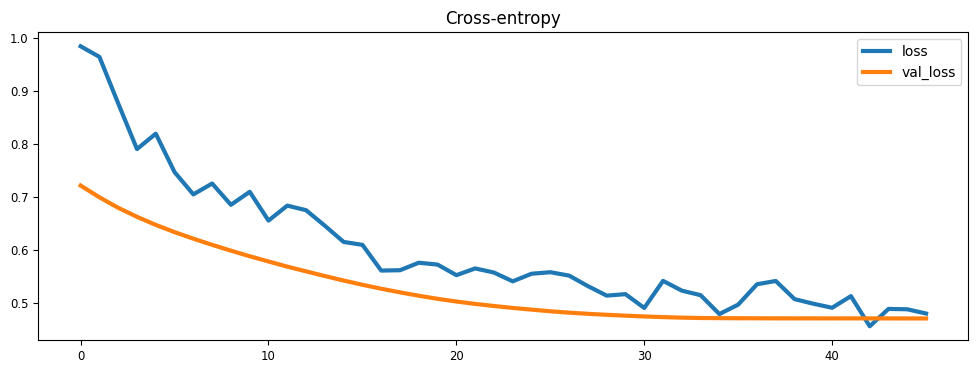

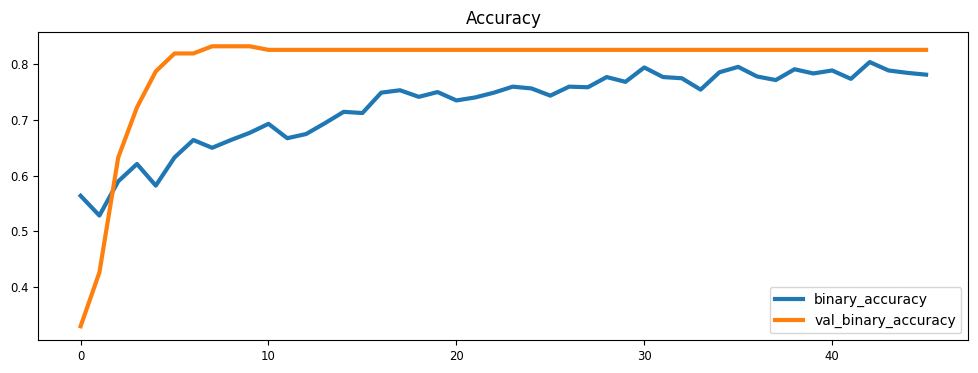

In [17]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    steps_per_epoch = 2,
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

In [18]:
print(("\nBest Loss: {:0.4f}" +\
       "\nBest Accuracy: {:0.4f}" +\
       "\nBest Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['loss'].min(),
              history_df['binary_accuracy'].max(),
              history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))


Best Loss: 0.4564
Best Accuracy: 0.8039
Best Validation Loss: 0.4711
Best Validation Accuracy: 0.8323


In [19]:
X.sample(1)

,gender,married,dependents,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_term_month,loan_term_year,credit_history,property_type
371,Male,No,0,Graduate,No,5124.0,0.0,124000,360,30,0.0,studio


In [20]:
test_data = {
    'gender': 'Male',
    'married': 'Yes',
    'dependents': '0',
    'education': 'Graduate',
    'self_employed': 'No',
    'property_type': 'apartment',
    'applicant_income': 5000.0,
    'coapplicant_income': 2000.0,
    'loan_amount': 150000,
    'loan_term_month': 360,
    'loan_term_year': 30,
    'credit_history': 1.0
}

input_df = pd.DataFrame([test_data])

input_transformed = preprocessor.transform(input_df)

In [21]:
# Melakukan prediksi
prediction = model.predict(input_transformed)
prediction = np.round(prediction.flatten())

# Menampilkan hasil prediksi
print('Loan Status:', 'APPROVE' if prediction == 1 else 'REJECT')

1/1 [==============================] - 0s 356ms/step
Loan Status: APPROVE
